In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import SGDClassifier, LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, mean_absolute_percentage_error

sns.set(style='whitegrid')
np.set_printoptions(suppress=True) # get rid of the scientific notation

***
## Based on the work by Nataliia Rastoropova

- [See Article](https://medium.com/analytics-vidhya/step-by-step-guide-for-predicting-wine-quality-using-scikit-learn-de5869f8f91a)
- [See Notebook](https://gist.github.com/NataliiaRastoropova/1d861775c47516d99e8dcb444eaa7049)
***

In [2]:
# Load in the red wine dataset

df = pd.read_csv('red_wine.csv', sep=';')

# list(df.columns)
# print(*df.columns, sep='\n')

In [3]:
df[:5]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()
print(f'shape : {df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
shape : (1599, 12)


In [5]:
# missing values
df.isna().sum().sort_values(ascending=False)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
# duplicate data is most commonly rows of data that are exactly the same across all columns
df.duplicated().any()

True

In [7]:
df.loc[df.duplicated(keep=False)].shape

(460, 12)

+ remove duplicates

In [8]:
# remove duplicates
df = df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)

In [9]:
df.duplicated().any()

False

In [10]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.0,8.310596,1.736990,4.60000,7.1000,7.9000,9.20000,15.90000
volatile acidity,1359.0,0.529478,0.183031,0.12000,0.3900,0.5200,0.64000,1.58000
citric acid,1359.0,0.272333,0.195537,0.00000,0.0900,0.2600,0.43000,1.00000
residual sugar,1359.0,2.523400,1.352314,0.90000,1.9000,2.2000,2.60000,15.50000
chlorides,1359.0,0.088124,0.049377,0.01200,0.0700,0.0790,0.09100,0.61100
free sulfur dioxide,1359.0,15.893304,10.447270,1.00000,7.0000,14.0000,21.00000,72.00000
total sulfur dioxide,1359.0,46.825975,33.408946,6.00000,22.0000,38.0000,63.00000,289.00000
density,1359.0,0.996709,0.001869,0.99007,0.9956,0.9967,0.99782,1.00369
pH,1359.0,3.309787,0.155036,2.74000,3.2100,3.3100,3.40000,4.01000
sulphates,1359.0,0.658705,0.170667,0.33000,0.5500,0.6200,0.73000,2.00000


In [11]:
# features ranges
df.describe().loc[['min', 'max']].T

,min,max
fixed acidity,4.60000,15.90000
volatile acidity,0.12000,1.58000
citric acid,0.00000,1.00000
residual sugar,0.90000,15.50000
chlorides,0.01200,0.61100
free sulfur dioxide,1.00000,72.00000
total sulfur dioxide,6.00000,289.00000
density,0.99007,1.00369
pH,2.74000,4.01000
sulphates,0.33000,2.00000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 127.5 KB


***
## Data visualization
***

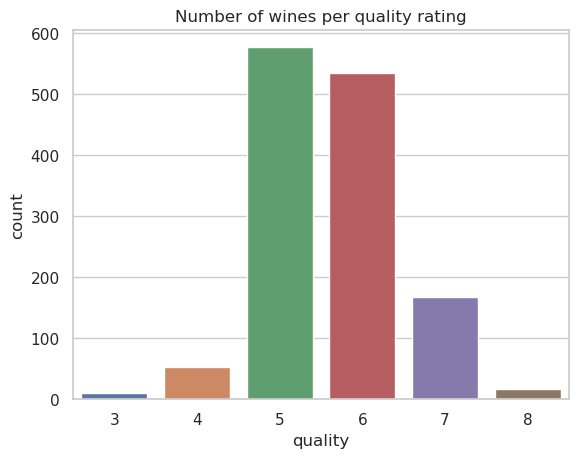

In [13]:
sns.countplot(x=df['quality'])
plt.title('Number of wines per quality rating')
plt.show()

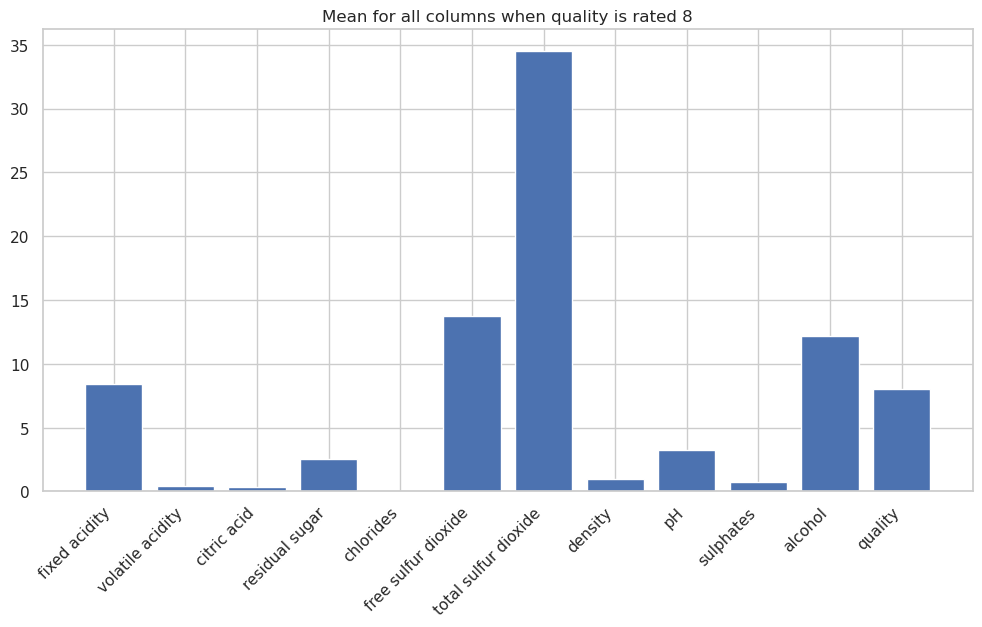

In [14]:
plt.figure(figsize=(12, 6))
plt.bar(df.columns, df[df['quality'] == 8].mean())
plt.title('Mean for all columns when quality is rated 8')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [15]:
# create pivot table (group by quality, aggregation function = median)

columns_names = df.columns[:-1]
df_pivot_table = df.pivot_table(columns_names, ['quality'], aggfunc='median')
df_pivot_table.sort_index(ascending=False)

,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity
quality,,,,,,,,,,,
8,12.500,0.0710,0.390,0.994720,7.9,8.0,3.23,2.0,0.740,24.0,0.380
7,11.600,0.0720,0.400,0.995770,8.8,11.0,3.28,2.3,0.740,27.0,0.370
6,10.500,0.0780,0.270,0.996520,7.9,14.0,3.32,2.2,0.640,35.0,0.490
5,9.600,0.0820,0.230,0.997000,7.8,15.0,3.30,2.2,0.580,49.0,0.580
4,10.000,0.0800,0.090,0.996500,7.5,11.0,3.37,2.1,0.560,26.0,0.670
3,9.925,0.0905,0.035,0.997565,7.5,6.0,3.39,2.1,0.545,15.0,0.845


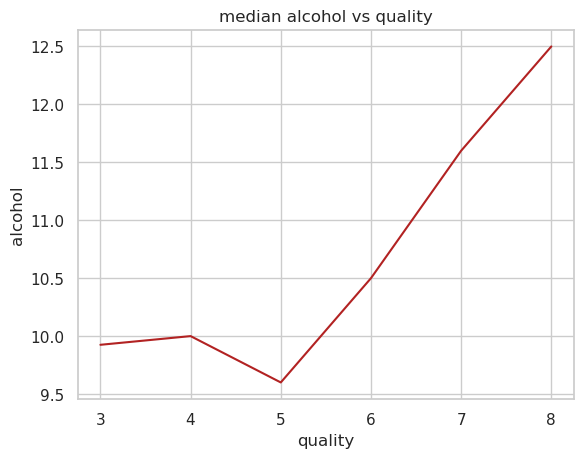

In [16]:
sns.lineplot(df_pivot_table['alcohol'], color='firebrick', markers=True)
plt.title('median alcohol vs quality')
plt.show()

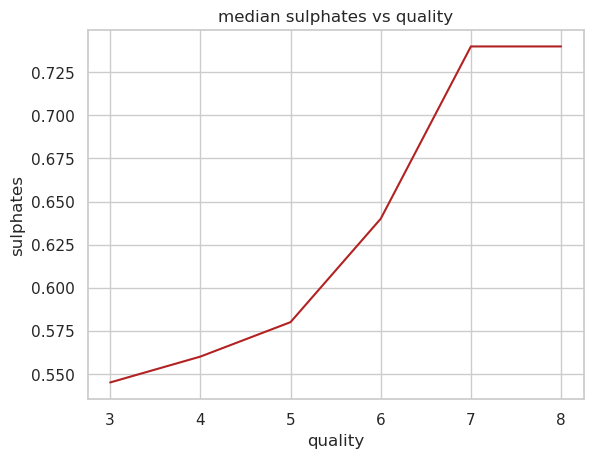

In [17]:
sns.lineplot(df_pivot_table['sulphates'], color='firebrick', markers=True)
plt.title('median sulphates vs quality')
plt.show()

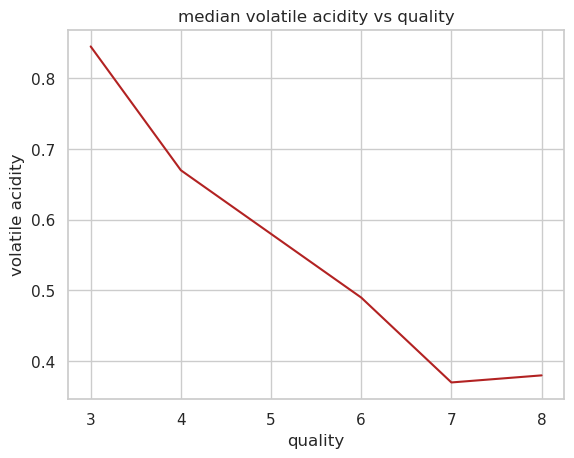

In [18]:
sns.lineplot(df_pivot_table['volatile acidity'], color='firebrick', markers=True)
plt.title('median volatile acidity vs quality')
plt.show()

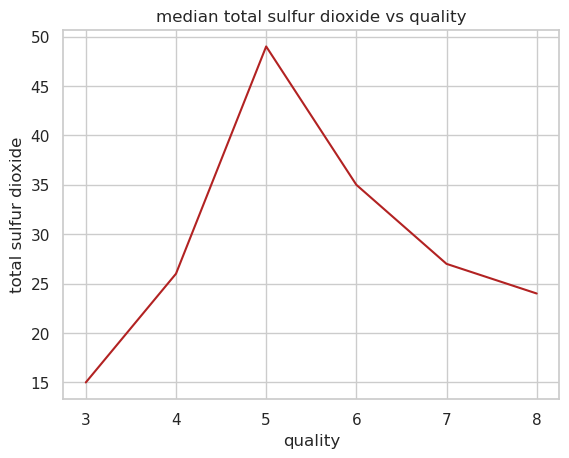

In [19]:
sns.lineplot(df_pivot_table['total sulfur dioxide'], color='firebrick', markers=True)
plt.title('median total sulfur dioxide vs quality')
plt.show()

+ histograms

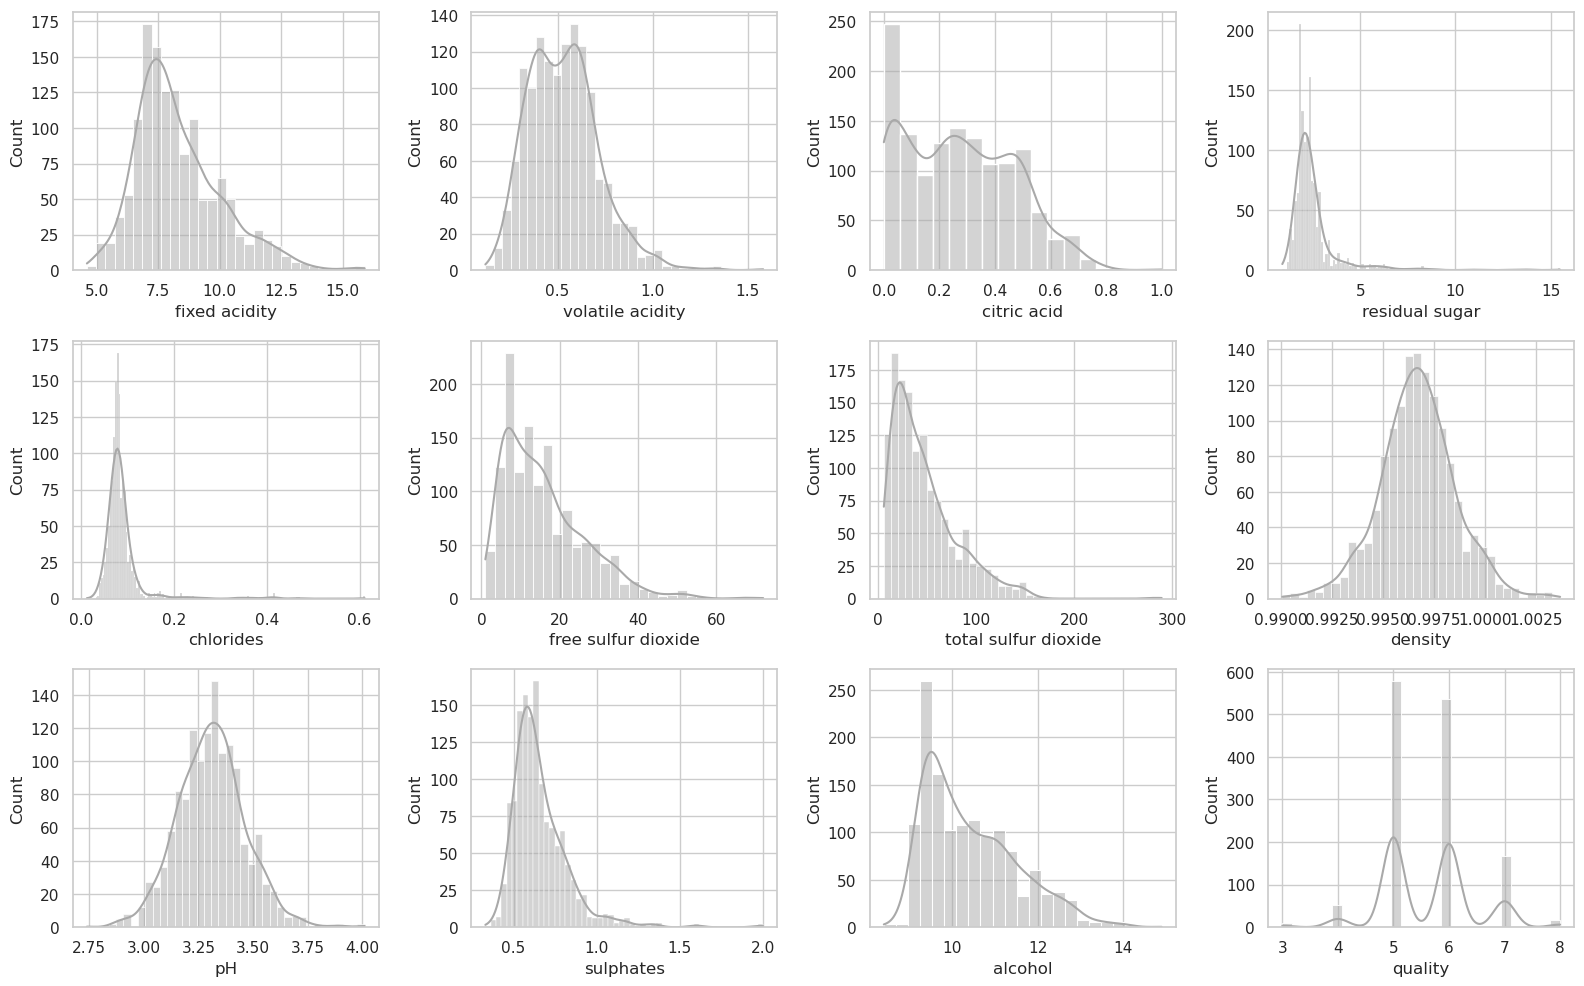

In [20]:
plt.figure(figsize=(16, 10))

for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[column], kde=True, color='darkgrey')
    
plt.tight_layout()
plt.show()

# df.drop(columns='quality').hist(bins=30, figsize=(10, 10))
# plt.tight_layout()
# plt.show()

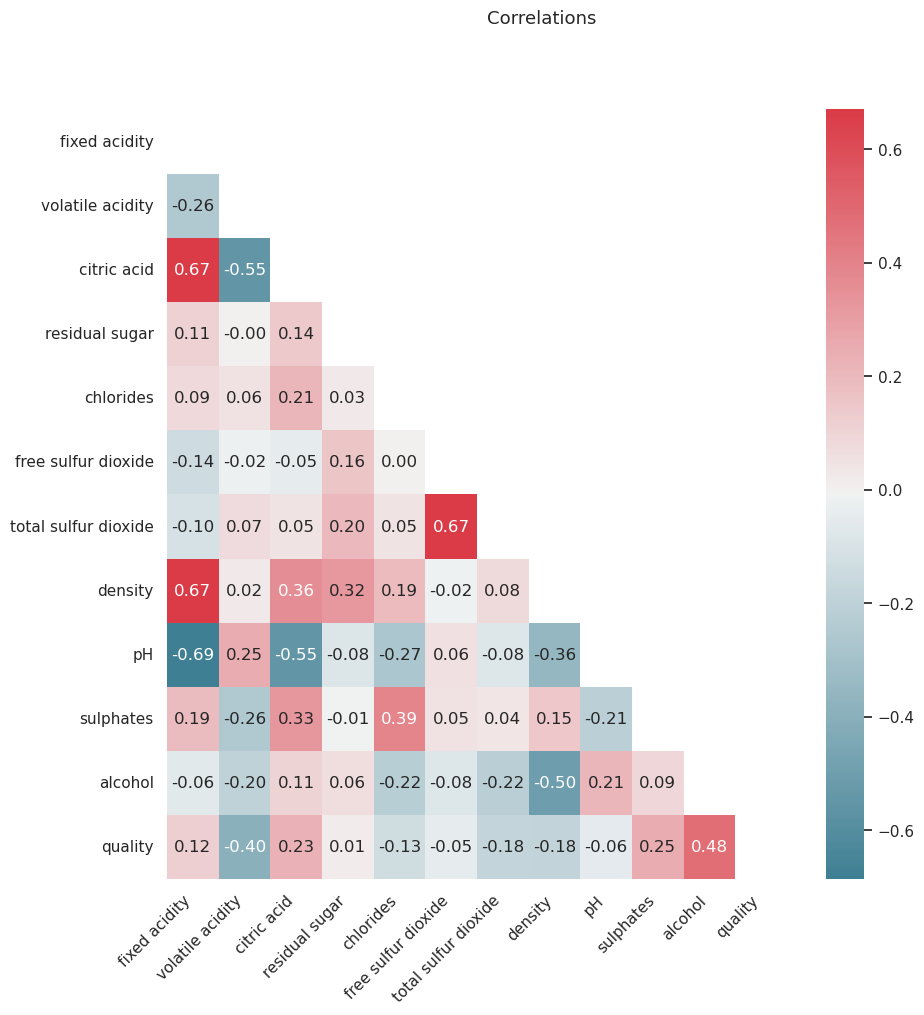

In [21]:
# correlation matrix

corr_matrix = df.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Correlations', fontsize=13)

# generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr_matrix, mask=mask, cmap=colormap, annot=True, fmt='.2f')
ax.set_xticklabels(df.columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(df.columns)
plt.show()

***
## Data Preprocessing
***

In [22]:
# top features for classification

estimator = f_classif
selector = SelectKBest(estimator, k=len(df.columns)-1)
selector = selector.fit(df.drop(columns='quality'), df['quality'])
d = {'Features': df.drop(columns='quality').columns, 'Keep': selector.get_support(), 'Scores': selector.scores_}
features = pd.DataFrame(data = d).sort_values(by='Scores', ascending=False).reset_index(drop=True)
features

,Features,Keep,Scores
0,alcohol,True,103.437849
1,volatile acidity,True,53.444371
2,total sulfur dioxide,True,23.025815
3,sulphates,True,18.537139
4,citric acid,True,16.290843
5,density,True,12.857528
6,chlorides,True,5.401693
7,fixed acidity,True,5.185218
8,free sulfur dioxide,True,4.792748
9,pH,True,4.377319


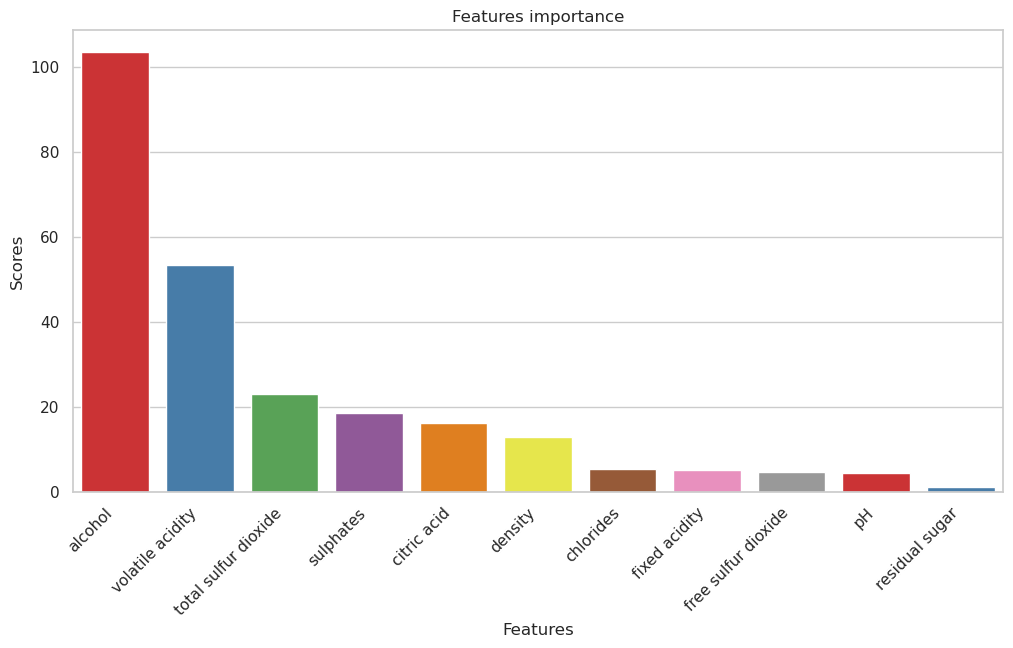

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='Features', y='Scores', data=features, ax=ax, palette='Set1')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Features importance')
plt.show()

In [24]:
# compute VIF for each independent variable

vif = pd.DataFrame()
df_selected = df.drop(columns='quality')
vif['features'] = df_selected.columns
vif['vif_factor'] = [variance_inflation_factor(df_selected.values, i) for i in range(df_selected.shape[1])]
vif.sort_values(by='vif_factor', ascending=False).reset_index()

,index,features,vif_factor
0,7,density,1500.387873
1,8,pH,1095.732046
2,10,alcohol,123.097449
3,0,fixed acidity,75.023032
4,9,sulphates,21.946341
5,1,volatile acidity,16.460387
6,2,citric acid,9.188892
7,6,total sulfur dioxide,6.543918
8,5,free sulfur dioxide,6.432241
9,4,chlorides,6.349793


+ dropping features

In [25]:
# drop density and pH

df = df.drop(columns=['density', 'pH'])

In [26]:
vif = pd.DataFrame()
df_selected = df.drop(columns='quality')
vif['features'] = df_selected.columns
vif['vif_factor'] = [variance_inflation_factor(df_selected.values, i) for i in range(df_selected.shape[1])]
vif.sort_values(by='vif_factor', ascending=False).reset_index()

,index,features,vif_factor
0,0,fixed acidity,37.030433
1,8,alcohol,36.856500
2,7,sulphates,21.622546
3,1,volatile acidity,15.091381
4,2,citric acid,8.619115
5,5,free sulfur dioxide,6.342563
6,6,total sulfur dioxide,5.974092
7,4,chlorides,5.706700
8,3,residual sugar,4.912710


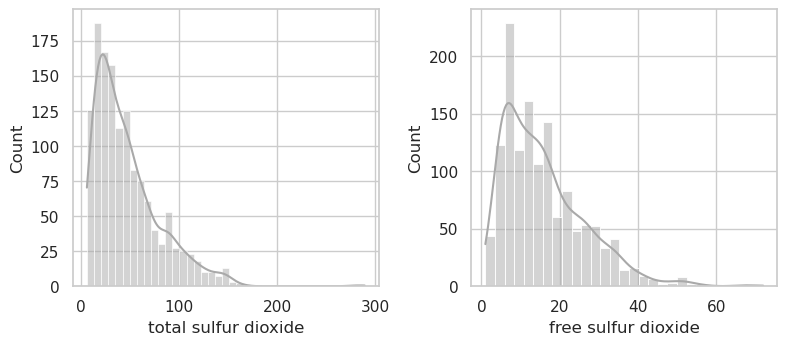

In [27]:
plt.figure(figsize=(16, 10))

for i, column in enumerate(df[['total sulfur dioxide', 'free sulfur dioxide']].columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[column], kde=True, color='darkgrey')
    
plt.tight_layout()
plt.show()

In [28]:
df[['total sulfur dioxide', 'free sulfur dioxide']] = df[['total sulfur dioxide', 'free sulfur dioxide']].apply(lambda x:np.log(x))

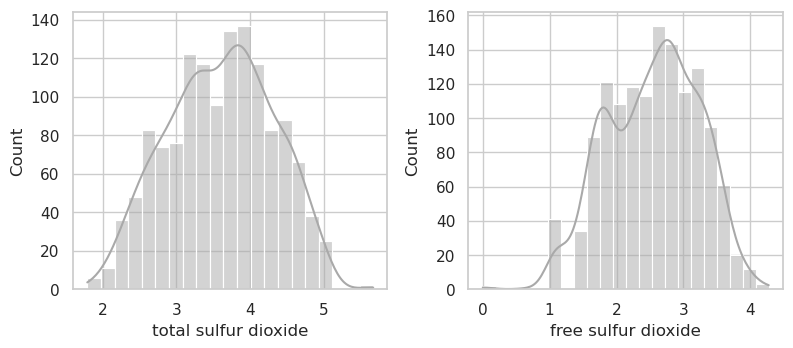

In [29]:
plt.figure(figsize=(16, 10))

for i, column in enumerate(df[['total sulfur dioxide', 'free sulfur dioxide']].columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[column], kde=True, color='darkgrey')
    
plt.tight_layout()
plt.show()

* making bins

In [30]:
# making bins for the response variable

# [0, 6]  : low
# [7, 10] : high


bins = (0, 6, 10)
group_names = ['low', 'high']
df['quality'] = pd.cut(df['quality'], bins=bins, labels=group_names)

In [31]:
df['quality'].value_counts()

low     1175
high     184
Name: quality, dtype: int64

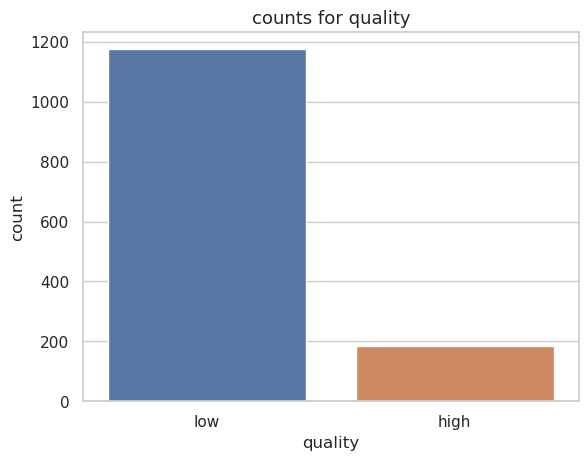

In [32]:
sns.countplot(x=df['quality'])
plt.title('counts for quality', fontsize=13)
plt.show()

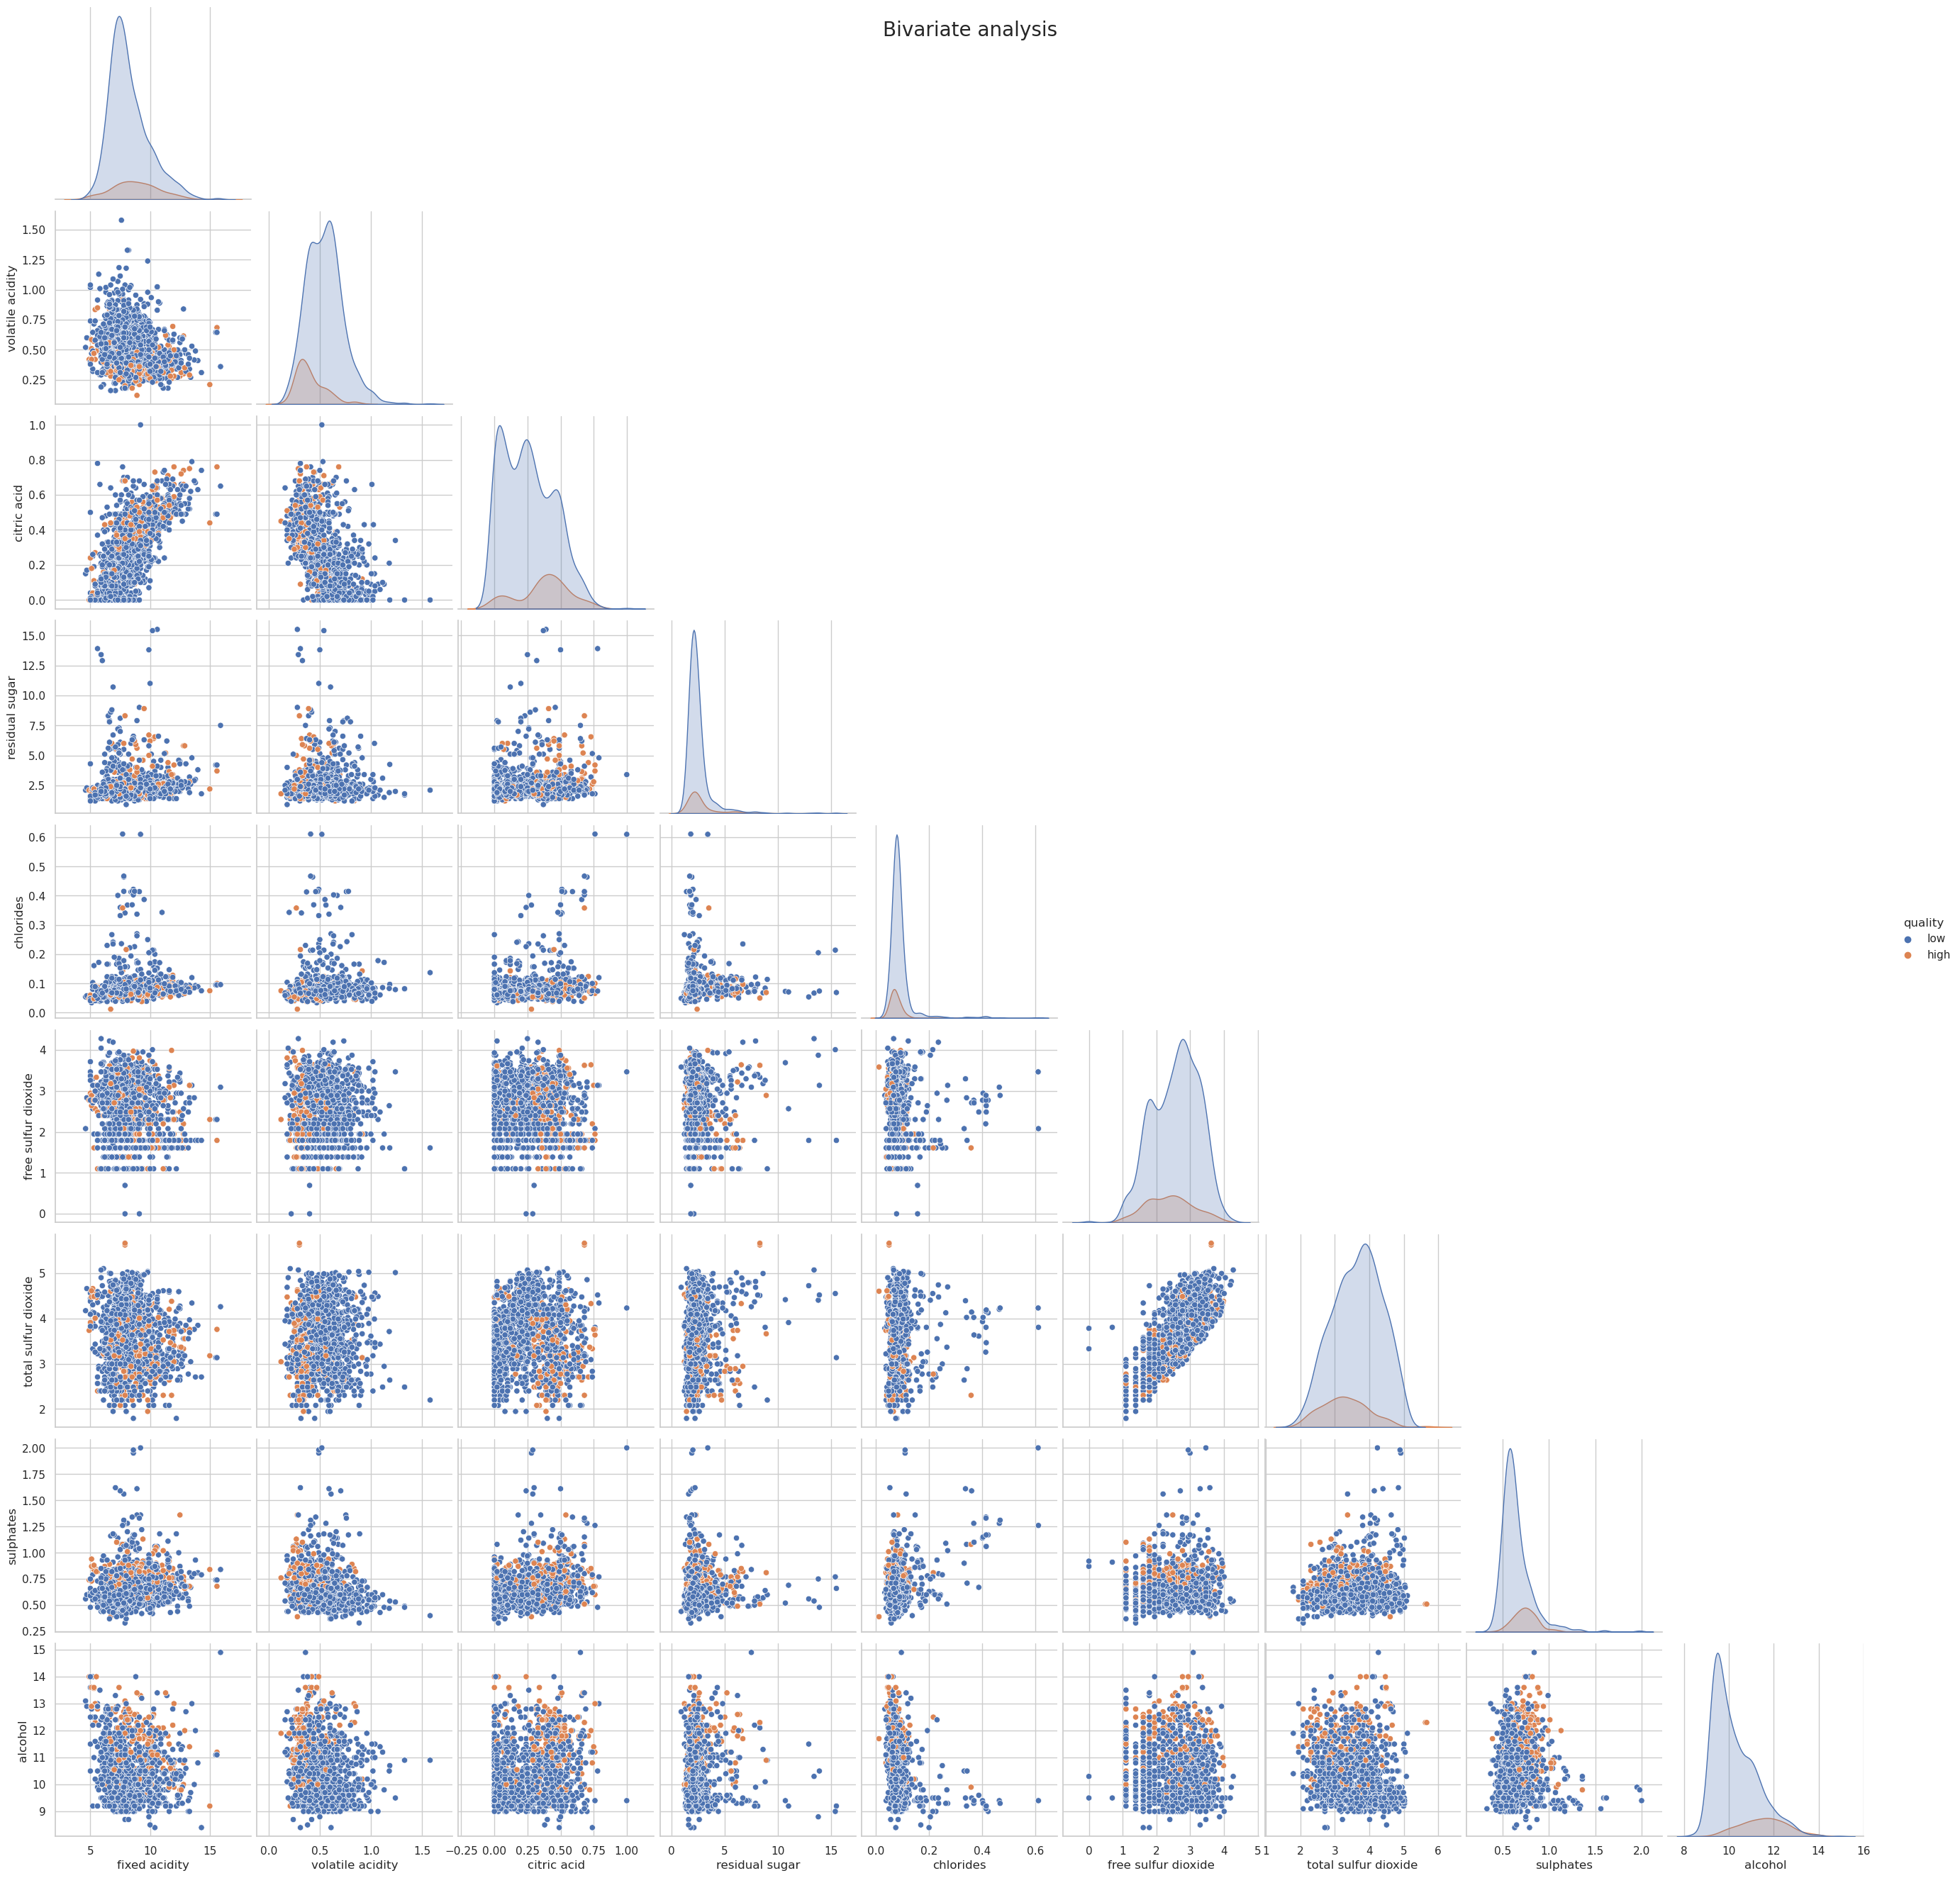

In [33]:
sns.pairplot(df, hue='quality', diag_kind='kde', corner=True, height=3)
plt.suptitle('Bivariate analysis', fontsize=20)
plt.show()

In [34]:
length = np.arange(0, len(group_names))
my_dict = {key:value for (key, value) in zip(group_names, length)}
df['quality'] = df['quality'].replace(my_dict)

# ratings = ['bad', 'average', 'good']
# oe = OrdinalEncoder(categories=[ratings], handle_unknown='use_encoded_value', unknown_value=np.nan)
# df['quality'] = oe.fit_transform(df[['quality']])

In [35]:
df['quality'].value_counts().sort_index()

0    1175
1     184
Name: quality, dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         1359 non-null   float64 
 1   volatile acidity      1359 non-null   float64 
 2   citric acid           1359 non-null   float64 
 3   residual sugar        1359 non-null   float64 
 4   chlorides             1359 non-null   float64 
 5   free sulfur dioxide   1359 non-null   float64 
 6   total sulfur dioxide  1359 non-null   float64 
 7   sulphates             1359 non-null   float64 
 8   alcohol               1359 non-null   float64 
 9   quality               1359 non-null   category
dtypes: category(1), float64(9)
memory usage: 97.1 KB


In [37]:
# separate the dataset as response variable and features variables

# On récupère les variables explicatives
X = df.drop(columns='quality')

# On récupère la variable à expliquer
y = df['quality']

In [38]:
# oversampling

oversample = SMOTE(random_state=1, k_neighbors=5)
X, y = oversample.fit_resample(X, y)

In [39]:
# train and test splitting of data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [40]:
# standard scaling to get optimized results

# initialisation
scaler = StandardScaler()

# training
scaler.fit(X_train)

# transform 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# confirm that the scaled dataset is centered at zero, with unit variance

print('Train:')
print(X_train.mean(axis=0))
print(X_train.std(axis=0))

print('\nTest:')
print(X_test.mean(axis=0))
print(X_test.std(axis=0))

Train:
[ 0. -0. -0. -0.  0. -0.  0.  0. -0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]

Test:
[ 0.03000516  0.07374324 -0.02102026 -0.01913938  0.05164518  0.03236722
  0.04571784 -0.03009598 -0.04627885]
[1.03597693 1.02408268 1.0615458  0.90882884 1.32228592 0.94616862
 0.96122939 0.9586033  0.98164125]


In [42]:
X_train_df = pd.DataFrame(X_train, columns = df.drop(columns='quality').columns)

In [43]:
X_train_df['quality']= y_train

In [44]:
X_train_df['quality'].value_counts()

0    927
1    571
Name: quality, dtype: int64

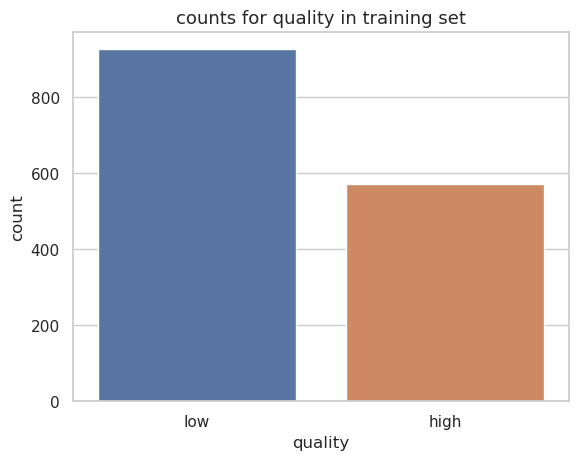

In [45]:
sns.countplot(x=X_train_df['quality'])
plt.xticks(ticks=(0,1), labels=('low', 'high'))
plt.title('counts for quality in training set', fontsize=13)
plt.show()

In [46]:
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=X_train_df, palette='Set3')
# plt.xticks(rotation=45, horizontalalignment='right')
# plt.show()

***
## Machine learning algorithms
***

In [47]:
seed = 1

# prepare models
models = []
models.append(('SupportVectorClassifier', SVC(random_state=seed)))
models.append(('StochasticGradientDecentC', SGDClassifier(random_state=seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state=seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=seed)))
models.append(('GaussianNB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state=seed)))
models.append(('GradientBoostClassifier', GradientBoostingClassifier(random_state=seed)))
models.append(('LogisticRegression', LogisticRegression(random_state=seed)))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=k_fold)
    results.append(cv_results)
    names.append(name)
    msg = '%s: mean= %0.3f ; standard deviation= %0.3f' % (name, cv_results.mean(), cv_results.std())
    print(msg)

SupportVectorClassifier: mean= 0.877 ; standard deviation= 0.019
StochasticGradientDecentC: mean= 0.802 ; standard deviation= 0.045
RandomForestClassifier: mean= 0.917 ; standard deviation= 0.021
DecisionTreeClassifier: mean= 0.873 ; standard deviation= 0.020
GaussianNB: mean= 0.798 ; standard deviation= 0.029
KNeighborsClassifier: mean= 0.866 ; standard deviation= 0.022
AdaBoostClassifier: mean= 0.859 ; standard deviation= 0.025
GradientBoostClassifier: mean= 0.878 ; standard deviation= 0.026
LogisticRegression: mean= 0.818 ; standard deviation= 0.026


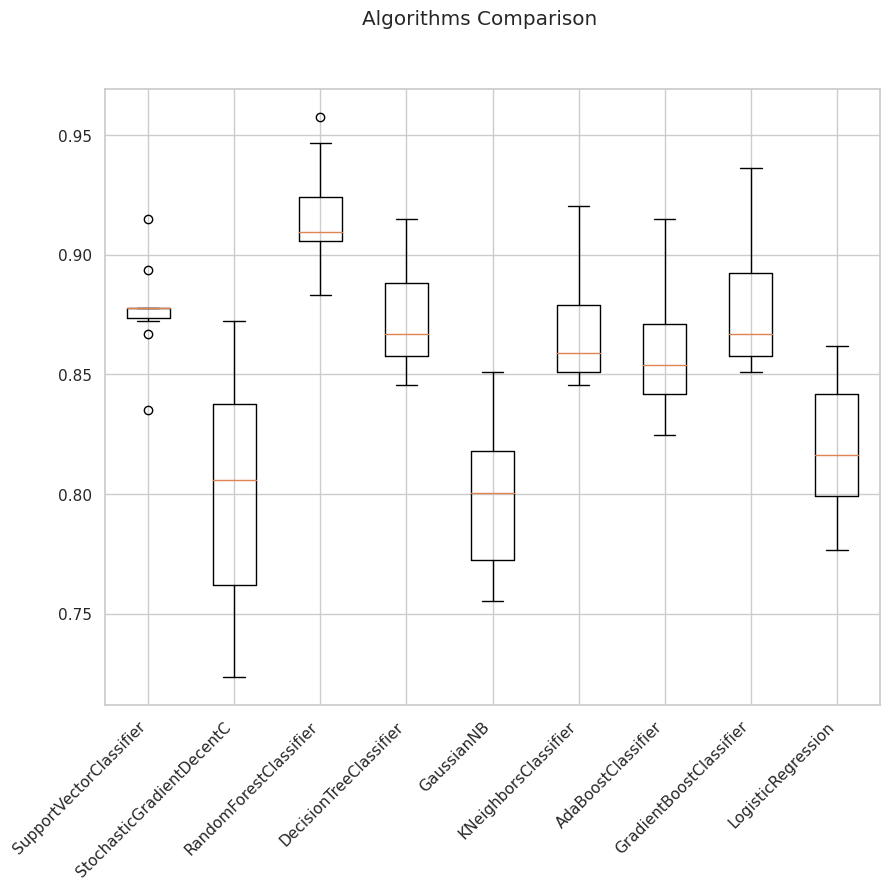

In [48]:
# boxplot algorithm comparison

fig = plt.figure(figsize=(10, 8))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=45, horizontalalignment='right')
plt.show()

In [49]:
# define results for machine learning algorithms

def results(pred):
    print('Classification report\n\n', classification_report(y_test, pred, zero_division=0, target_names=group_names))
    print('Accuracy score', round(accuracy_score(y_test, pred), 3))

**1) Support Vector Classifier**

In [50]:
# # grid search, finding best parameters for SVC model

# param = {'C': np.arange(1, 1.5, .1),
#          'kernel':['linear', 'rbf'],
#          'gamma' :np.arange(1, 2, .1)}

# svc = SVC(random_state=1)
# grid_svc = GridSearchCV(svc, param_grid=param, n_jobs=-1)
# grid_svc.fit(X_train, y_train)
# grid_svc.best_params_

In [51]:
svc = SVC(C = 1.2, gamma = 1.7, kernel= 'rbf', random_state=1)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
results(pred_svc)

Classification report

               precision    recall  f1-score   support

         low       0.97      0.98      0.97       248
        high       0.97      0.96      0.97       222

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470

Accuracy score 0.97


**2) Random Forest Classifier**


In [52]:
# # grid search, finding best parameters for random forest model

# parameters = {'n_estimators': np.arange(50, 100, 1),
#               'max_depth': np.arange(5, 20, 1)}

# rfc = RandomForestClassifier(random_state=1)
# grid_rfc = GridSearchCV(estimator=rfc, param_grid=parameters, n_jobs=-1)
# grid_rfc.fit(X_train, y_train)
# grid_rfc.best_params_

In [53]:
rfc = RandomForestClassifier(n_estimators=94, max_depth=15, random_state=1, n_jobs=-1)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
results(pred_rfc)

Classification report

               precision    recall  f1-score   support

         low       0.97      0.90      0.93       248
        high       0.90      0.96      0.93       222

    accuracy                           0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.93      0.93      0.93       470

Accuracy score 0.93


**3) KNN Classifier**

In [54]:
# always choose odd number for n_neighbors

nbrs = KNeighborsClassifier(weights='uniform', n_neighbors=2, n_jobs=-1)
nbrs.fit(X_train,y_train)
pred_nbrs = nbrs.predict(X_test)
results(pred_nbrs)

Classification report

               precision    recall  f1-score   support

         low       0.97      0.88      0.92       248
        high       0.87      0.97      0.92       222

    accuracy                           0.92       470
   macro avg       0.92      0.92      0.92       470
weighted avg       0.92      0.92      0.92       470

Accuracy score 0.919


**4) Gradient Boost Classifier**

In [55]:
# # grid search, finding best parameters for SVC model

# param = {'learning_rate': np.arange(.2, .25, .01),
#          'max_depth': np.arange(4, 8, 1),
#          'n_estimators': np.arange(180, 210, 10)}

# gbc = GradientBoostingClassifier(random_state=1)
# grid_gbc = GridSearchCV(gbc, param_grid=param, n_jobs=-1)
# grid_gbc.fit(X_train, y_train)
# grid_gbc.best_params_

In [56]:
gbc = GradientBoostingClassifier(learning_rate=.23, n_estimators=190, max_depth=6, random_state=1)
gbc.fit(X_train, y_train)
pred_gbc = gbc.predict(X_test)
results(pred_gbc)

Classification report

               precision    recall  f1-score   support

         low       0.97      0.94      0.95       248
        high       0.93      0.97      0.95       222

    accuracy                           0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470

Accuracy score 0.953


**5) Cross validation for support vector classifier**

In [57]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_result = cross_val_score(svc, X_test, y_test, cv=k_fold)
round(cv_result.mean(), 3)

0.891

**6) Confusion matrix for support vector classifier**

<img src='confusionMatrix.jpg' width=500px>

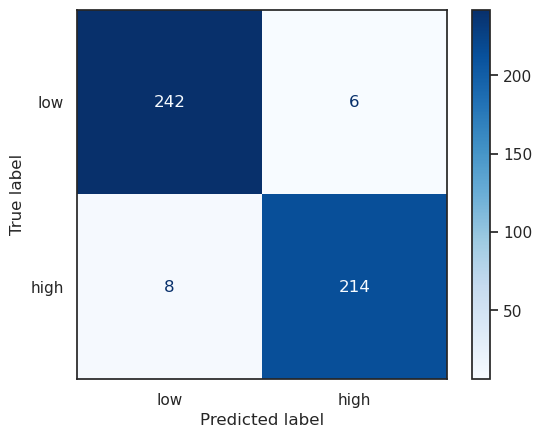

In [58]:
sns.set(style='white')
ConfusionMatrixDisplay.from_predictions(y_test, pred_svc, display_labels=group_names, cmap='Blues')
plt.show()

**7) Features importance**

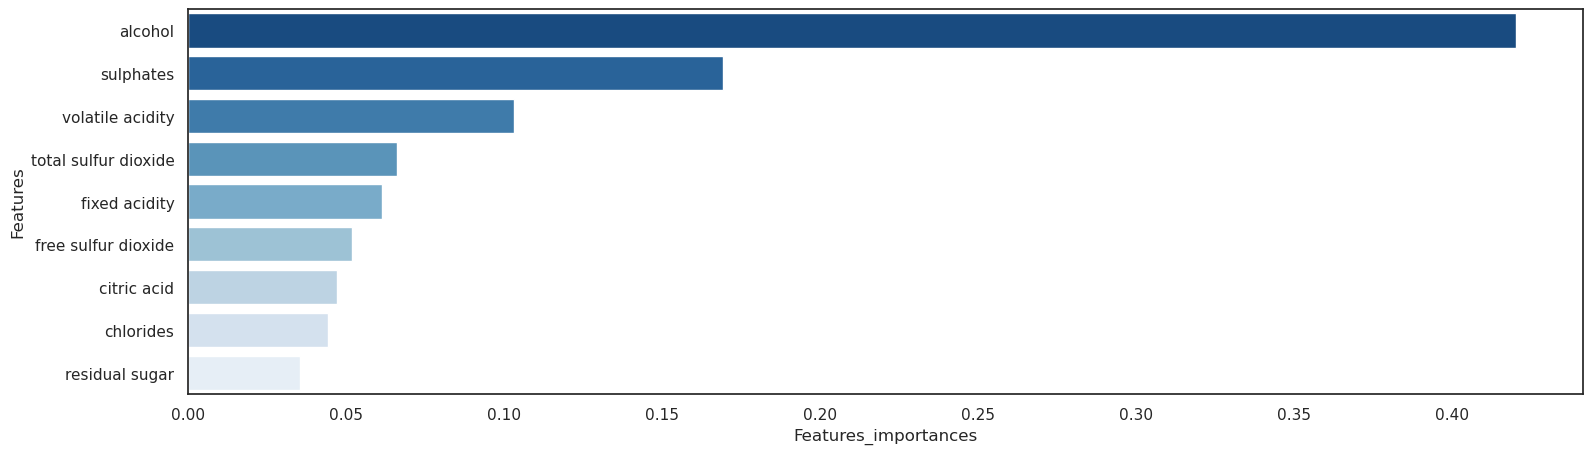

In [59]:
fig, ax = plt.subplots(figsize=(18, 5))

features = pd.DataFrame({'Features' : df.columns[:-1], 'Features_importances' : gbc.feature_importances_}).sort_values(by='Features_importances', ascending=False)
sns.barplot(x='Features_importances', y='Features', data=features, ax=ax, orient='h', palette='Blues_r')
plt.show()

***
## Conclusion
***

- Quality note is a sensory evaluation, based on the tasting process.
- Note is singled out by an expert who take into account attributes which are not the physico-chemical ones, and therefore are not present in the data set.
- These lacking attributes limit the performance of our model (max accuracy = 89 %).
- Examples of these lacking can be opacity, viscosity, and some unknown subjective tasting attributes that are linked to the tasting expert.